In [1]:
%matplotlib inline

import warnings
from pathlib import Path
import os
from datetime import datetime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

from statsmodels.api import OLS, add_constant
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.metrics import roc_auc_score
from sklearn.externals import joblib

In [2]:
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
np.random.seed(42)
pd.options.display.float_format = '{:,.4f}'.format

In [3]:
with pd.HDFStore('model_tuning.h5') as store:
    test_feature_data = store['holdout/features']
    test_features = test_feature_data.columns
    test_target = store['holdout/target']

## GBM GridsearchCV with sklearn

Need OneStepTimeSeriesSplit because stored GridSearchCV result expects it

In [4]:
class OneStepTimeSeriesSplit:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the index contains a level labeled 'date'"""

    def __init__(self, n_splits=3, test_period_length=1, shuffle=False):
        self.n_splits = n_splits
        self.test_period_length = test_period_length
        self.shuffle = shuffle
        self.test_end = n_splits * test_period_length

    @staticmethod
    def chunks(l, n):
        for i in range(0, len(l), n):
            yield l[i:i + n]

    def split(self, X, y=None, groups=None):
        unique_dates = (X.index
                        .get_level_values('date')
                        .unique()
                        .sort_values(ascending=False)
                        [:self.test_end])

        dates = X.reset_index()[['date']]
        for test_date in self.chunks(unique_dates, self.test_period_length):
            train_idx = dates[dates.date < min(test_date)].index
            test_idx = dates[dates.date.isin(test_date)].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

### Load Result

Need to run `sklearn_gbm_tuning.py` to perform gridsearch and store result.

In [ ]:
gridsearch_result = joblib.load('gbm_gridsearch.joblib')

### Best Parameters & AUC Score

In [6]:
pd.Series(gridsearch_result.best_params_)

learning_rate             0.0100
max_depth                 9.0000
max_features              1.0000
min_impurity_decrease     0.0100
min_samples_split        10.0000
n_estimators            300.0000
subsample                 0.8000
dtype: float64

In [7]:
f'{gridsearch_result.best_score_:.4f}'

'0.6853'

### Evaluate best model

#### Test on hold-out set

In [8]:
best_model = gridsearch_result.best_estimator_

In [9]:
preds= best_model.predict(test_feature_data)

In [10]:
roc_auc_score(y_true=test_target, y_score=preds)

0.6622470619909608

#### Inspect global feature importance

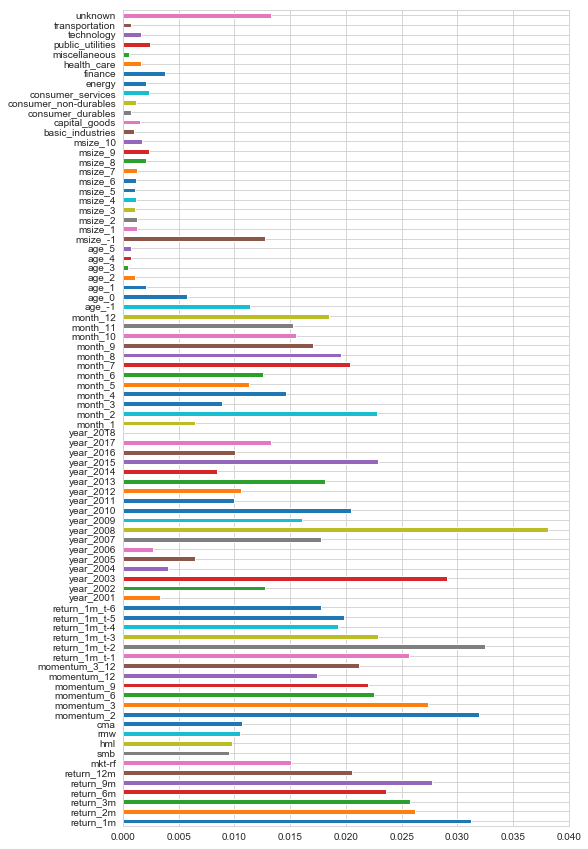

In [12]:
pd.Series(best_model.feature_importances_, index=test_features).plot.barh(figsize=(8,15));

### CV Train-Test Scores

In [13]:
results = pd.DataFrame(gridsearch_result.cv_results_).drop('params', axis=1)
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 40 columns):
mean_fit_time                  576 non-null float64
std_fit_time                   576 non-null float64
mean_score_time                576 non-null float64
std_score_time                 576 non-null float64
param_learning_rate            576 non-null object
param_max_depth                576 non-null object
param_max_features             576 non-null object
param_min_impurity_decrease    576 non-null object
param_min_samples_split        576 non-null object
param_n_estimators             576 non-null object
param_subsample                576 non-null object
split0_test_score              576 non-null float64
split1_test_score              576 non-null float64
split2_test_score              576 non-null float64
split3_test_score              576 non-null float64
split4_test_score              576 non-null float64
split5_test_score              576 non-null float64
split6_test_score 

In [14]:
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_max_features,param_min_impurity_decrease,param_min_samples_split,param_n_estimators,...,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,split10_train_score,split11_train_score,mean_train_score,std_train_score
0,107.0407,4.7653,0.0150,0.0014,0.0100,3,sqrt,0,10,100,...,0.6271,0.6295,0.6300,0.6325,0.6336,0.6279,0.6295,0.6332,0.6280,0.0042
1,113.1462,2.6408,0.0190,0.0042,0.0100,3,sqrt,0,10,100,...,0.6250,0.6275,0.6261,0.6259,0.6299,0.6370,0.6345,0.6336,0.6268,0.0059
2,309.6415,8.1426,0.0220,0.0029,0.0100,3,sqrt,0,10,300,...,0.6436,0.6445,0.6472,0.6410,0.6439,0.6469,0.6497,0.6464,0.6445,0.0028
3,329.9059,7.1890,0.0222,0.0018,0.0100,3,sqrt,0,10,300,...,0.6421,0.6435,0.6464,0.6431,0.6451,0.6472,0.6478,0.6440,0.6446,0.0019
4,106.8347,3.4506,0.0158,0.0020,0.0100,3,sqrt,0,50,100,...,0.6247,0.6265,0.6296,0.6262,0.6348,0.6297,0.6372,0.6337,0.6279,0.0050


### Get parameter values & mean test scores

In [15]:
test_scores = results.filter(like='param').join(results[['mean_test_score']])
test_scores = test_scores.rename(columns={c: '_'.join(c.split('_')[1:]) for c in test_scores.columns})
test_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 8 columns):
learning_rate            576 non-null object
max_depth                576 non-null object
max_features             576 non-null object
min_impurity_decrease    576 non-null object
min_samples_split        576 non-null object
n_estimators             576 non-null object
subsample                576 non-null object
test_score               576 non-null float64
dtypes: float64(1), object(7)
memory usage: 36.1+ KB


In [16]:
params = test_scores.columns[:-1].tolist()

In [17]:
test_scores = test_scores.set_index('test_score').stack().reset_index()
test_scores.columns= ['test_score', 'parameter', 'value']
test_scores.head()

,test_score,parameter,value
0,0.6640,learning_rate,0.0100
1,0.6640,max_depth,3
2,0.6640,max_features,sqrt
3,0.6640,min_impurity_decrease,0
4,0.6640,min_samples_split,10


In [18]:
test_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4032 entries, 0 to 4031
Data columns (total 3 columns):
test_score    4032 non-null float64
parameter     4032 non-null object
value         4032 non-null object
dtypes: float64(1), object(2)
memory usage: 94.6+ KB


In [19]:
def get_test_scores(df):
    """Select parameter values and test scores"""
    data = df.filter(like='param').join(results[['mean_test_score']])
    return data.rename(columns={c: '_'.join(c.split('_')[1:]) for c in data.columns})

### Plot Test Scores vs Parameter Settings

In [20]:
plot_data = get_test_scores(results).drop('min_impurity_decrease', axis=1)
plot_params = plot_data.columns[:-1].tolist()
plot_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 7 columns):
learning_rate        576 non-null object
max_depth            576 non-null object
max_features         576 non-null object
min_samples_split    576 non-null object
n_estimators         576 non-null object
subsample            576 non-null object
test_score           576 non-null float64
dtypes: float64(1), object(6)
memory usage: 31.6+ KB


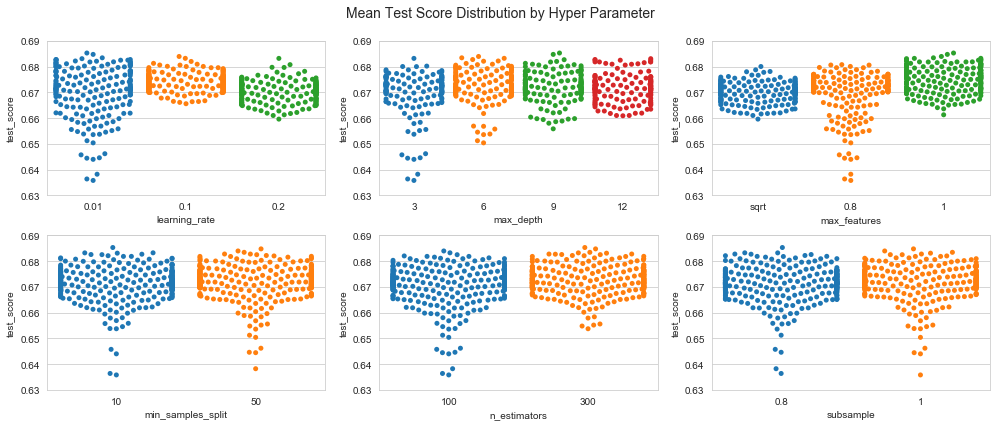

In [21]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(14, 6))
axes = axes.flatten()

for i, param in enumerate(plot_params):
    sns.swarmplot(x=param, y='test_score', data=plot_data, ax=axes[i])
    axes[i].set_ylim(.63, .69)
    
fig.suptitle('Mean Test Score Distribution by Hyper Parameter', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.9)
fig.savefig('mean_test_scores_by_param', dpi=300);

### Dummy-encode parameters

In [22]:
data = get_test_scores(results)
params = data.columns[:-1].tolist()
data = pd.get_dummies(data,columns=params, drop_first=False)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 19 columns):
test_score                    576 non-null float64
learning_rate_0.01            576 non-null uint8
learning_rate_0.1             576 non-null uint8
learning_rate_0.2             576 non-null uint8
max_depth_3                   576 non-null uint8
max_depth_6                   576 non-null uint8
max_depth_9                   576 non-null uint8
max_depth_12                  576 non-null uint8
max_features_0.8              576 non-null uint8
max_features_1                576 non-null uint8
max_features_sqrt             576 non-null uint8
min_impurity_decrease_0.0     576 non-null uint8
min_impurity_decrease_0.01    576 non-null uint8
min_samples_split_10          576 non-null uint8
min_samples_split_50          576 non-null uint8
n_estimators_100              576 non-null uint8
n_estimators_300              576 non-null uint8
subsample_0.8                 576 non-null uint8
subsample_1

### Build Regression Tree

In [23]:
reg_tree = DecisionTreeRegressor(criterion='mse',
                                 splitter='best',
                                 max_depth=4,
                                 min_samples_split=5,
                                 min_samples_leaf=10,
                                 min_weight_fraction_leaf=0.0,
                                 max_features=None,
                                 random_state=42,
                                 max_leaf_nodes=None,
                                 min_impurity_decrease=0.0,
                                 min_impurity_split=None,
                                 presort=False)

In [24]:
gbm_features = data.drop('test_score', axis=1).columns
reg_tree.fit(X=data[gbm_features], y=data.test_score)

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=10,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

#### Visualize Tree

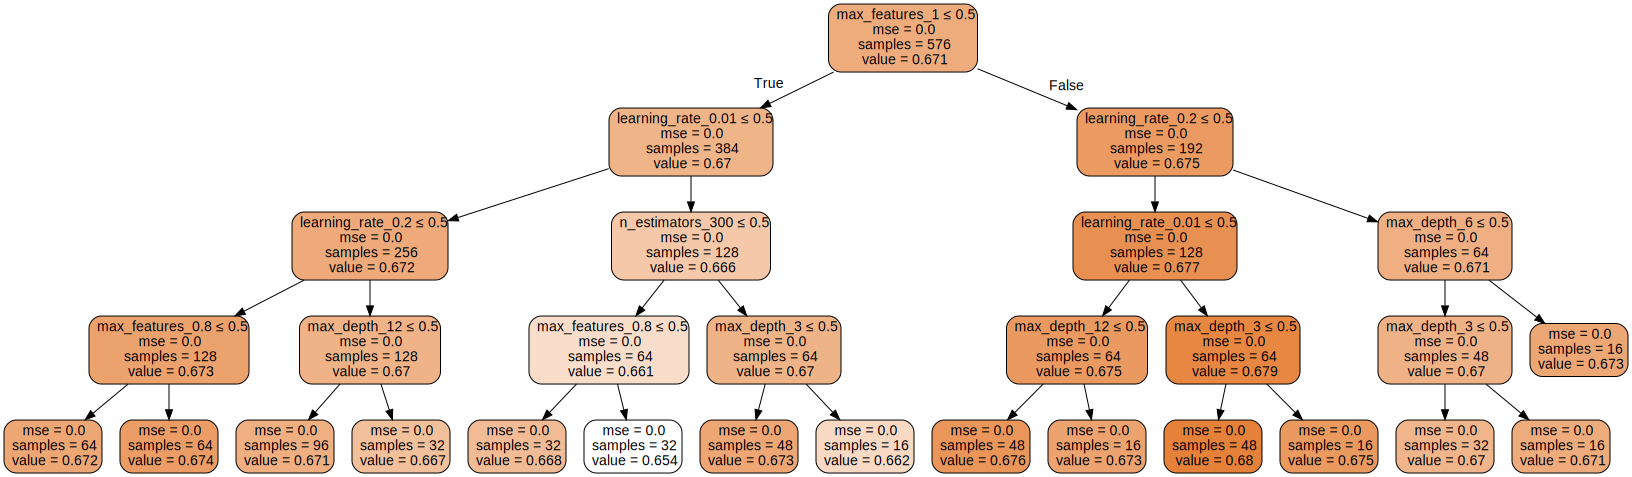

In [25]:
out_file = 'gbm_sklearn_tree.dot'
dot_data = export_graphviz(reg_tree,
                          out_file=out_file,
                          feature_names=gbm_features,
                          max_depth=4,
                          filled=True,
                          rounded=True,
                          special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)

#### Compute Feature Importance

Overfit regression tree to learn detailed rules that classify all samples

In [71]:
reg_tree = DecisionTreeRegressor(criterion='mse',
                                 splitter='best',
                                 min_samples_split=2,
                                 min_samples_leaf=1,
                                 min_weight_fraction_leaf=0.0,
                                 max_features=None,
                                 random_state=42,
                                 max_leaf_nodes=None,
                                 min_impurity_decrease=0.0,
                                 min_impurity_split=None,
                                 presort=False)

gbm_features = data.drop('test_score', axis=1).columns
reg_tree.fit(X=data[gbm_features], y=data.test_score)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

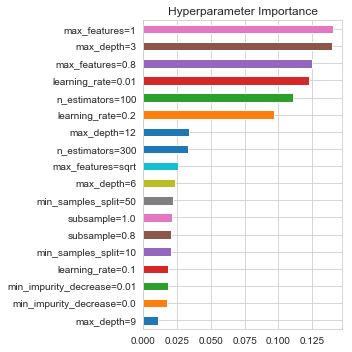

In [85]:
gbm_fi = pd.Series(reg_tree.feature_importances_, index=gbm_features).sort_values(ascending=False)
gbm_fi = gbm_fi[gbm_fi > 0]
idx = [p.split('_') for p in gbm_fi.index]
gbm_fi.index = ['_'.join(p[:-1]) + '=' + p[-1] for p in idx]
gbm_fi.sort_values().plot.barh(figsize=(5,5))
plt.title('Hyperparameter Importance')
plt.tight_layout()
plt.savefig('param_importance', dpi=300);

### Run linear regression

In [75]:
data = get_test_scores(results)
params = data.columns[:-1].tolist()
data = pd.get_dummies(data,columns=params, drop_first=True)

model = OLS(endog=data.test_score, exog=add_constant(data.drop('test_score', axis=1))).fit(cov_type='HC3')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             test_score   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     21.38
Date:                Tue, 23 Oct 2018   Prob (F-statistic):           1.86e-36
Time:                        09:41:54   Log-Likelihood:                 2159.6
No. Observations:                 576   AIC:                            -4295.
Df Residuals:                     564   BIC:                            -4243.
Df Model:                          11                                         
Covariance Type:                  HC3                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               